In [17]:
import netCDF4
import matplotlib.pyplot as plt
import json
from datetime import datetime, timezone
import os
import numpy as np
from pyproj import Transformer
import dfm_tools as dfmt
import sys
import xarray as xr

In [18]:
from datalakes import parse_nc_datalakes_from_folder, get_timeserie_datalakes, get_profile_datalakes
from delft3d_flow import get_closest_index_by_coord, extract_timeseries_from_output_file_by_coordinates
from alplakes import try_download, download_3d_timeserie_from_api, parse_alplakes_3d_timeserie_from_directory, download_3d_profile_from_api, parse_json_3d_profile_to_df

# Comparison of results from Delft3D Flow, Delft 3D Fm, Alplakes and measurements from Datalakes
This notebook displays :
- the timeserie of the temperature at a given location and depth
- the profile of the temperature at a given location and time
- the heatmap of the profile at a given location

It imports the measure from a netcdf file that can be dowloaded on the datalake platform (https://www.datalakes-eawag.ch/data).
If download_and_merge_timeserie_json = True, then it downloads a month of simulation results on Alplakes via the API (https://www.alplakes.eawag.ch/api) and merges it in the existing json file (if it exist). (a month is roughly the max period supported by the API for Lugano lake).
It imports local results from Delft3D flow and Delft3D FM (MapFormat=4) simulations.

In [19]:
lake_name = "lugano"
sta_name = 'lugano_figino'

depth_plot = 0
date_plot_profil = datetime(2023,8,1,0,0)

In [20]:
start_download_alplakes = '202306010000'
end_download_alplakes = '202307010000'
download_timeserie_alplakes = False

In [21]:
date_plot_profil_str = date_plot_profil.strftime('%Y%m%d%H%M')

In [46]:
# Alplakes simulation results
alplakes_json_timeserie_directory = rf"C:\Users\leroquan\Documents\00-Work_space\03-Results simu Alplakes\{sta_name}\timeseries_{depth_plot}m"
alplakes_profile_json_path = rf"C:\Users\leroquan\Documents\00-Work_space\03-Results simu Alplakes\{sta_name}\profiles\profile_{sta_name}_{date_plot_profil_str}m.json"
# Local simulation results
flow_output_file = r"C:\Users\leroquan\Documents\python\alplakes-simulations\runs\lugano_ope_20230402_20231001\output\trim-Simulation_Web.nc"
# Local FM simulation results
fm_model = 'lugano_1y_10part_corr_thick'

In [23]:
with open(r'Delft3D_FM\config_plots.json', 'r') as file:
    config_plots = json.load(file)[fm_model]
    
fm_output_file = config_plots['file_nc_map']
if 'partition_number' in config_plots:
    output_dir = config_plots['working_dir']
    n_part = config_plots['partition_number']
    fm_output_file = []
    for n in range(n_part):
        fm_output_file.append(os.path.join(output_dir, f'FlowFM_{n:04}_map.nc'))

In [24]:
with open(os.path.join('config_points.json'), 'r') as file:
    config_points = json.load(file)[sta_name]
    
lat_station_wgs84 = config_points['lat_station_wgs84']
long_station_wgs84 = config_points['long_station_wgs84']
measure_file_path = config_points['measure_file_path']

In [25]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:21781") # WGS84 projection to CH1903 projection
lat_station_ch1903, long_station_ch1903 = transformer.transform(lat_station_wgs84, long_station_wgs84)

# Get data

## Import measure

In [26]:
xr_measure= xr.open_mfdataset(measure_file_path)
# xr_measure = parse_nc_datalakes_from_folder(measure_folder_path)

meas_timeserie = get_timeserie_datalakes(xr_measure, 'temp', depth_plot)
meas_profile = get_profile_datalakes(xr_measure, 'temp', date_plot_profil)

## Import results Alplakes simulation

### Timeserie

In [65]:
download_timeserie_alplakes=False

In [41]:
if download_timeserie_alplakes == True:
    alplakes_download_file_path = os.path.join(alplakes_json_timeserie_directory,
                                f'timeserie_{lake_name}_{start_download_alplakes}_{end_download_alplakes}_{depth_plot}_{lat_station_wgs84}_{long_station_wgs84}.json')
    if not os.path.exists(alplakes_download_file_path):
        download_3d_timeserie_from_api(lake_name,start_download_alplakes,end_download_alplakes,depth_plot,lat_station_wgs84,long_station_wgs84,alplakes_download_file_path)

In [69]:
alplakes_timeserie = parse_alplakes_3d_timeserie_from_directory(alplakes_json_timeserie_directory)

### Profile

In [49]:
if not os.path.isfile(alplakes_profile_json_path):
    download_3d_profile_from_api()
alplakes_profile_data = parse_json_3d_profile_to_df(alplakes_profile_json_path)

## Import results local FLOW simulation

In [30]:
nc_flow = netCDF4.Dataset(flow_output_file)
flow_coor_index = get_closest_index_by_coord(np.array(nc_flow.variables["XZ"][:]), np.array(nc_flow.variables["YZ"][:]), lat_station_ch1903, long_station_ch1903)
flow_depth_index = (np.abs(np.array(nc_flow.variables["ZK_LYR"][:]) + depth_plot)).argmin()

flow_times = np.array(nc_flow.variables["time"][:])
flow_timestamps = [datetime.utcfromtimestamp(t + (datetime(2008, 3, 1).replace(tzinfo=timezone.utc) - datetime(1970, 1, 1).replace(tzinfo=timezone.utc)).total_seconds()).replace(tzinfo=timezone.utc) for t in flow_times]
flow_depths = np.array(nc_flow.variables["ZK_LYR"])
flow_x_coor_plot = np.array(nc_flow.variables["XZ"][flow_coor_index[0],flow_coor_index[1]])
flow_y_coor_plot = np.array(nc_flow.variables["YZ"][flow_coor_index[0],flow_coor_index[1]])

flow_data = np.array(nc_flow.variables['R1'][:,0,:,flow_coor_index[0],flow_coor_index[1]])
flow_data[flow_data == -999] = np.nan
flow_timeserie = flow_data[:,flow_depth_index]

transformer = Transformer.from_crs("EPSG:4326", "EPSG:21781") # WGS84 projection to CH1903 projection
lat_station_ch1903, long_station_ch1903 = transformer.transform(lat_station_wgs84, long_station_wgs84)
p = {"name": "Temperature", "variable": "R1", "pattern": [slice(None), 0, 'get_depth_index_from_depth', np.nan, np.nan], "depth":None, "x_coords": None, "y_coords": None}
local_sim_timestamps, local_sim_temp, local_sim_coor = extract_timeseries_from_output_file_by_coordinates(local_sim_output_file, p["variable"], p["pattern"], lat_station_ch1903, long_station_ch1903, depth_simu)

## Import results local FM simulation

In [31]:
fm_map = dfmt.open_partitioned_dataset(fm_output_file)

x_list = fm_map['mesh2d_face_x'].values
y_list = fm_map['mesh2d_face_y'].values
min_distance = sys.maxsize
fm_index_nFaces = None
for i in range(len(x_list)):
    # Calculate distance to the given coordinate
    distance = (x_list[i] - lat_station_ch1903) ** 2 + (y_list[i] - long_station_ch1903) ** 2
    if distance < min_distance:
        min_distance = distance
        fm_index_nFaces = i

fm_depths = fm_map['mesh2d_layer_z'].values
fm_index_depth = (np.abs(fm_depths + depth_plot)).argmin()
fm_timestamps = fm_map['time'].values
fm_timeserie = fm_map['mesh2d_tem1'].values[:, fm_index_nFaces, fm_index_depth]
fm_profil = fm_map['mesh2d_tem1'].values[:, fm_index_nFaces, :].transpose()

>> xu.open_dataset() with 10 partition(s): 1 2 3 4 5 6 7 8 9 10 : 5.98 sec
>> xu.merge_partitions() with 10 partition(s): 2.64 sec
>> dfmt.open_partitioned_dataset() total: 8.62 sec


# Plot

## Plot timeseries temperature at depth "depth_simu"

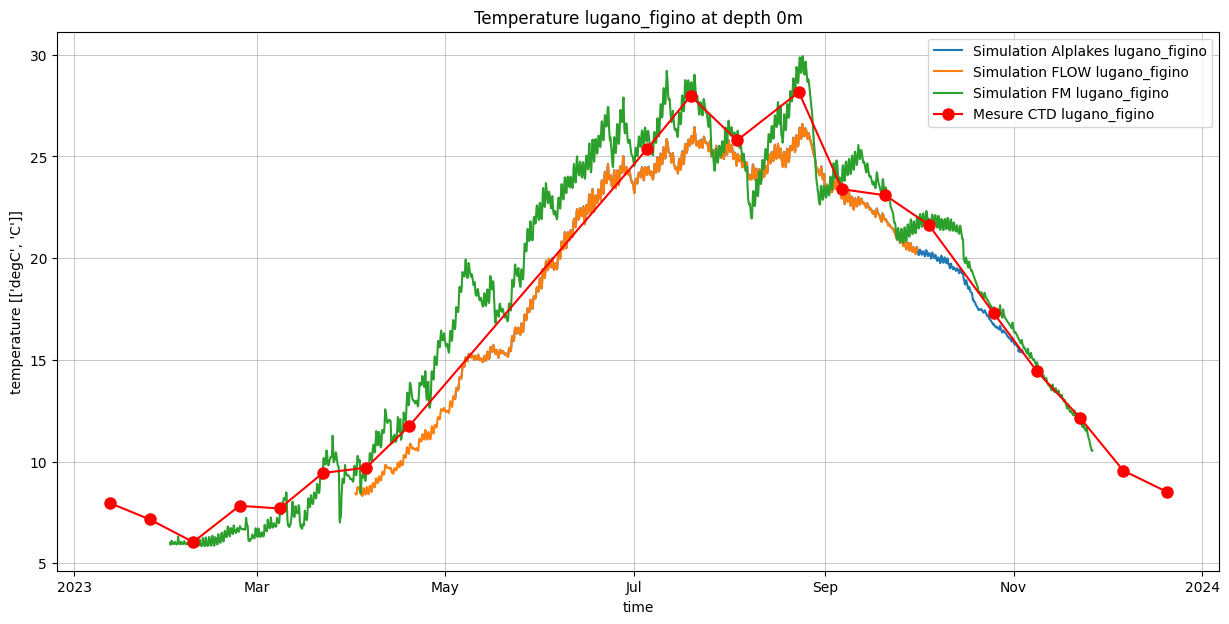

In [71]:
start_date = datetime(2023, 1, 1, 0, 0) 
end_date = datetime(2024, 1, 1, 0, 0)

fig = plt.figure(figsize=(15, 7))
plt.plot(alplakes_timeserie['time'],alplakes_timeserie['temperature'], label=f'Simulation Alplakes {sta_name}')
plt.plot(flow_timestamps,flow_timeserie, label=f'Simulation FLOW {sta_name}')
plt.plot(fm_timestamps,fm_timeserie, label=f'Simulation FM {sta_name}')
meas_timeserie.sel(time=slice(start_date,end_date)).plot(marker='o', label=f'Mesure CTD {sta_name}', color='r', markersize=8)
plt.title(f"Temperature {sta_name} at depth {depth_plot}m")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
plt.show()

#fig.savefig(rf'C:\Users\leroquan\Documents\01-Presentations\Aphys group meetings\2024 05 28\timeserie_{sta_name}_{depth_simu}m.png')

## Plot profils

In [33]:
i_flow_date_plot = (np.abs(np.array(flow_timestamps) - date_plot_profil.replace(tzinfo=timezone.utc))).argmin()
i_fm_date_plot = (np.abs(np.array(fm_timestamps) - np.datetime64(date_plot_profil))).argmin()

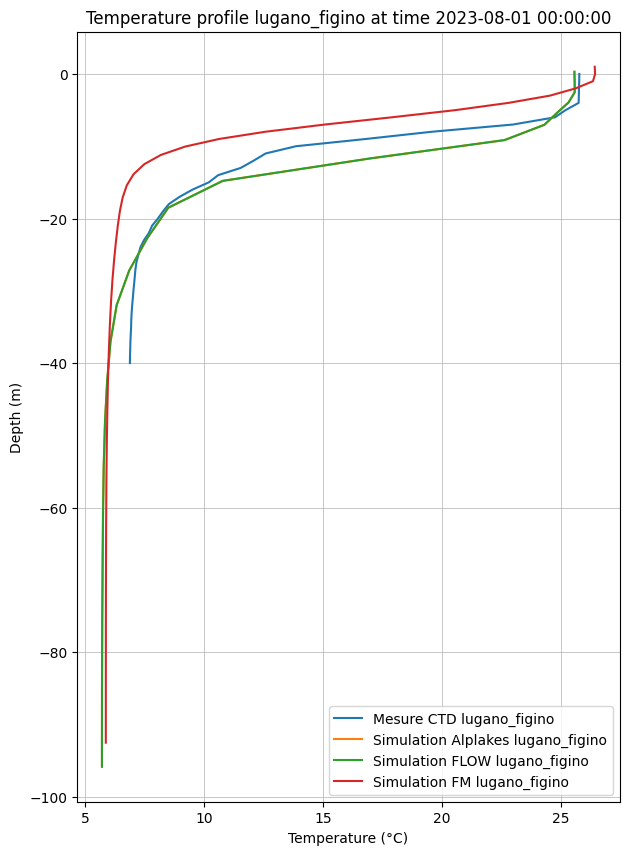

In [72]:
fig = plt.figure(figsize=(7, 10))
plt.plot(meas_profile.values,-1*meas_profile.depth.values, label=f'Mesure CTD {sta_name}')
plt.plot(alplakes_profile_data['temperature'],-1*alplakes_profile_data['depth'], label=f'Simulation Alplakes {sta_name}')
plt.plot(flow_data[i_flow_date_plot],flow_depths, label=f'Simulation FLOW {sta_name}') 
plt.plot(fm_profil[:,i_fm_date_plot], fm_depths, label=f'Simulation FM {sta_name}') 
plt.title(f"Temperature profile {sta_name} at time {date_plot_profil}")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.ylabel('Depth (m)')
plt.xlabel('Temperature (°C)')
plt.legend()
plt.show()

fig.savefig(rf'C:\Users\leroquan\Documents\01-Presentations\Aphys group meetings\2024 05 28\profile_{sta_name}_{date_plot_profil_str}_fm_detailed.png')

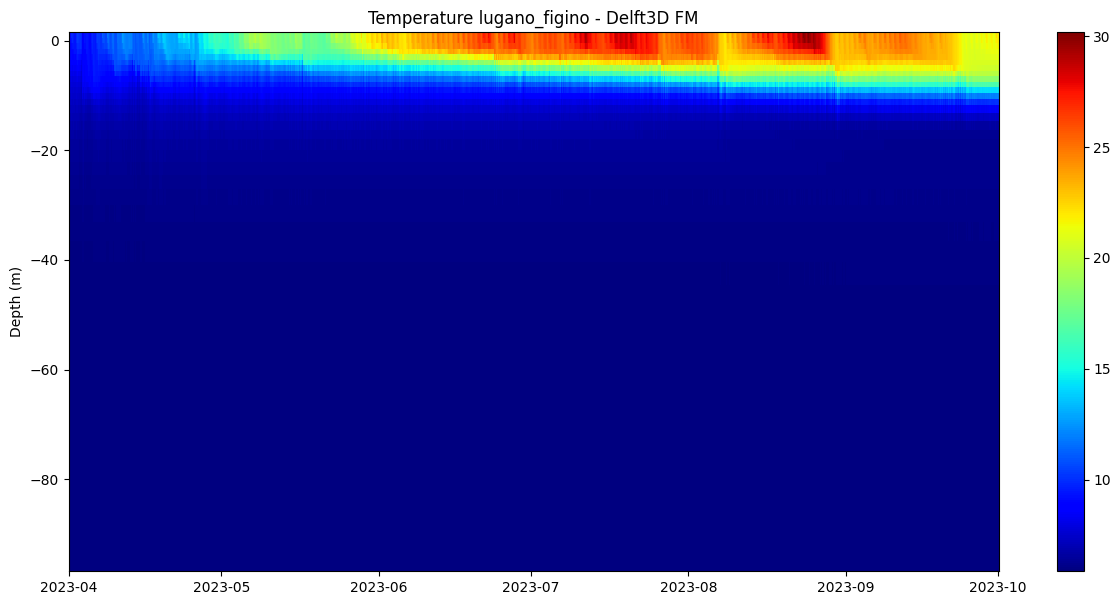

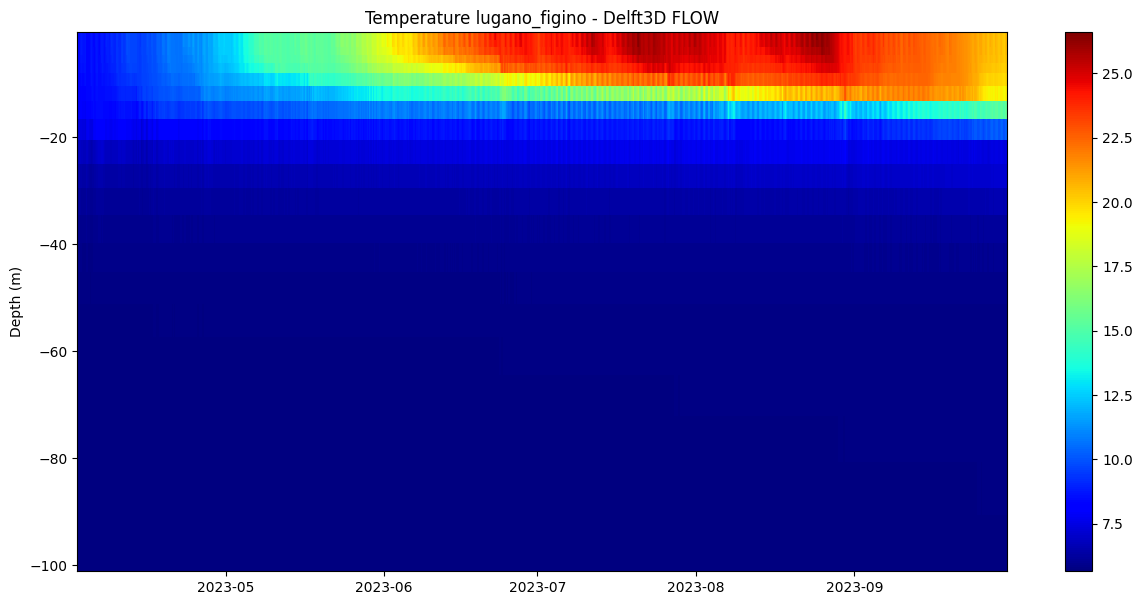

In [35]:
start_date = np.datetime64('2023-04-01') 
end_date = np.datetime64('2023-10-01')

# Find the index of the closest datetime object to start_date and end_date in meas_timestamps
fm_start_index = min(range(len(fm_timestamps)), key=lambda i: abs(fm_timestamps[i] - start_date))
fm_end_index = min(range(len(fm_timestamps)), key=lambda i: abs(fm_timestamps[i] - end_date))
mask_fm_nan_depth = np.isnan(fm_profil[:,0])==False

fig = plt.figure(figsize=(15,7))
plt.pcolormesh(fm_timestamps[fm_start_index:fm_end_index + 1], fm_depths[mask_fm_nan_depth], fm_profil[mask_fm_nan_depth,fm_start_index:fm_end_index + 1], cmap='jet')
plt.title(f"Temperature {sta_name} - Delft3D FM")
plt.ylabel("Depth (m)")
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(15,7))
plt.pcolormesh(flow_timestamps, flow_depths[28:49], flow_data.transpose()[28:49], cmap='jet')
plt.title(f"Temperature {sta_name} - Delft3D FLOW")
plt.ylabel("Depth (m)")
plt.colorbar()
plt.show()